In [27]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Sat Apr 23 16:20:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   54C    P2    45W / 250W |   3468MiB / 11019MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [4]:
# !kill -9 3980682

In [5]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 7
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [7]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [8]:
# !ls
data_zip_file = './local1_folder.zip'
bin_zip_file = './mountains.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

In [9]:
!nvidia-smi

Sat Apr 23 16:20:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   55C    P2   110W / 250W |   3468MiB / 11019MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Data preprocessing

## Image data

In [10]:
data_zip = zipfile.ZipFile(data_zip_file)

In [11]:
bin_zip = zipfile.ZipFile(bin_zip_file)

In [12]:
len(bin_zip.namelist())

1988

In [13]:
'mountains/mountains_000581.png' in bin_zip.namelist()

True

In [14]:
len(data_zip.namelist())

58766

In [15]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7FE2FD251FF0>
(734, 800, 3)


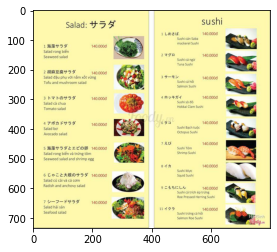

In [16]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

mountains/mountains_000122.png
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x333 at 0x7FE2D20DF730>
3


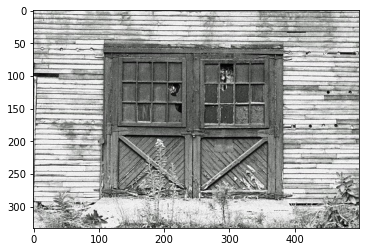

In [17]:
# img_path = bin_zip.namelist()[13]
img_path = 'mountains/mountains_000122.png'

print(img_path)
img = Image.open(bin_zip.open(img_path))
print(type(img))
print(img)
print(np.asarray(img).shape[2])
plt.imshow(img)

In [18]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [19]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [20]:
data_df4.shape

(3093, 11)

In [21]:
data_df4

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,Rating
0,4354468,18302878,1013381,Một thời quán sốt sình sịch trên các diễn đàn ...,https://images.foody.vn/res/g102/1013381/s800/...,10,9,8,9,9,9.0
1,3007299,9291597,859819,Đây là lần đầu tiên mình ăn ở quán papa's kitc...,https://images.foody.vn/res/g86/859819/s800/fo...,10,10,9,8,10,9.4
2,3573047,14176887,959528,Mình là ng rất hay đi ăn net hue. Nhưng phải n...,https://images.foody.vn/res/g96/959528/s800/fo...,3,1,5,4,4,3.4
3,6451930,8439488,959528,"Mình gọi 1 bánh bèo lẫn, 1 nem lụi, 1 hến xúc ...",https://images.foody.vn/res/g96/959528/s800/fo...,7,7,7,7,7,7.0
4,2521478,12153184,795394,"Quán có không gian vừa phải, sạch sẽ thoáng má...",https://images.foody.vn/res/g80/795394/s800/fo...,9,10,9,10,10,9.6
...,...,...,...,...,...,...,...,...,...,...,...
3088,62766,116623,67475,Nhà hàng khá đẹp và sang trọng. Thiết kế và tr...,https://images.foody.vn/res/g7/67475/s800/food...,8,8,8,7,7,7.6
3089,62262,114375,67475,"Nhà hàng sang trọng, không gian đẹp mà giá đồ ...",https://images.foody.vn/res/g7/67475/s800/food...,7,8,8,8,8,7.8
3090,2573700,14671922,714125,Chè Sầu Liên - Đà Nẵng 😱\nNgoài những món như ...,https://images.foody.vn/res/g72/714125/s800/fo...,10,9,5,5,10,7.8
3091,8801826,8596308,30377,Đi Nhật về thèm ăn bát Ramen nên thử vào Totoc...,https://images.foody.vn/res/g4/30377/s800/food...,1,2,2,1,1,1.4


In [22]:
# def insert_bin_image(df):
#     sample_df = df.sample(frac=0.05, random_state=0)
#     df.drop(sample_df.index, inplace=True)
#     df = df.reset_index(drop=True)
#     sample_df = sample_df.reset_index(drop=True)
#     for i in range(len(sample_df)):
#         list_img = []
#         for j in range(len(sample_df.iloc[i]['image_urls'].split(','))):
#             num_ran = random.randint(0, 900)
#             num_img = '0'* (6-len(str(num_ran))) + str(num_ran)
# #             mountains/mountains_000580.png
#             list_img.append('mountains/mountains_'+ num_img + '.png')
#         sample_df.loc[i,'image_urls'] = ','.join(list_img)
    
#     df = pd.concat([df, sample_df], ignore_index = True)
    
#     return df

# data_df4 = insert_bin_image(data_df4)
# data_df4

In [23]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [24]:
data_df.shape

(14174, 11)

In [25]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [26]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [27]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [29]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [30]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [31]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [32]:
data_df = data_df[data_df['label'] != 2]

1    6953
0    3023
Name: label, dtype: int64


<AxesSubplot:>

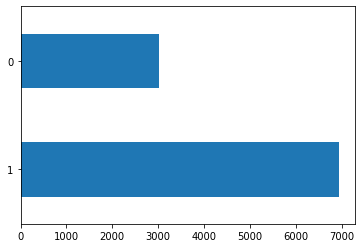

In [33]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [34]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [35]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [36]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [37]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [38]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

1    6952
0    3023
Name: label, dtype: int64


<AxesSubplot:>

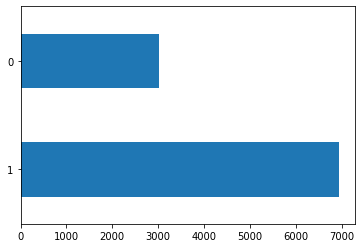

In [39]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [40]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [41]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [42]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [43]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(9, 8)

In [44]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [45]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

In [46]:
a

0        56
1        43
2        38
3        34
4        74
       ... 
9970     42
9971     48
9972    107
9973    185
9974     17
Name: preprocess_comment, Length: 9975, dtype: int64

In [47]:
data_df['Comment'][195]

'Sữa chua mít + trà đào ngon, caramen trong sữa chua ăn cũng ok, giá vừa phải. Quán sạch sẽ, nhân viên phục vụ tốt. Sẽ quay lại.'

<AxesSubplot:>

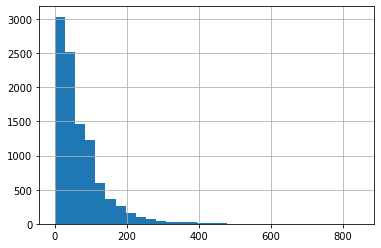

In [48]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [49]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    input_ids.append(bt[0]['input_ids'][0])
    attention_masks.append(bt[0]['attention_mask'][0])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])

  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks } , imgs_torch, img_len, labels

In [51]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
        if path in data_zip.namelist():
          img = Image.open(data_zip.open(path))
          if self.transform is not None:
            img = self.transform(img)
          img_list.append(img)
        else:
          img = Image.open(bin_zip.open(path))
          if self.transform is not None:
            img = self.transform(img)
          img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''
    
  def insert_bin_image(self, df):
    sample_df = df.sample(frac=0.4, random_state=0)
    df.drop(sample_df.index, inplace=True)
    df = df.reset_index(drop=True)
    sample_df = sample_df.reset_index(drop=True)
    for i in range(len(sample_df)):
        list_img = []
        for j in range(len(sample_df.iloc[i]['image_urls'].split(','))):
            num_img = ''
            img = ''
            while True:
                num_ran = random.randint(1, 900)
                num_img = '0'* (6-len(str(num_ran))) + str(num_ran)
                img = Image.open(bin_zip.open('mountains/mountains_'+ num_img + '.png'))
#                 print(len(np.asarray(img).shape))
                if len(np.asarray(img).shape) == 3:
                    break;
            list_img.append('mountains/mountains_'+ num_img + '.png')
        sample_df.loc[i,'image_urls'] = ','.join(list_img)
    
    df = pd.concat([df,sample_df], ignore_index = True)
    
    return df

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.train_data = self.insert_bin_image(self.train_data)
#       print(self.train_data)
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [52]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'].shape)
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
torch.Size([8, 150])
torch.Size([22, 3, 299, 299])
22
8


In [53]:
dm.train_data[7579:]

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
7579,6301,3480983,8306307,935166,Mình ăn Tofu truyền thống 49k thêm 4 loại topp...,"mountains/mountains_000234.png,mountains/mount...",8.2,1,mình ăn tofu truyền_thống 49k thêm 4 loại topp...
7580,8470,1713691,9828170,111524,Quán bar đáng lên án vì bán bổ Tôn Giáo người ...,mountains/mountains_000689.png,1.0,0,quán bar đáng lên_án vì bán bổ tôn_giáo người ...
7581,1301,2932590,378856,911519,Đây là lần đầu tiên mình ăn ở yakimono nhưng m...,"mountains/mountains_000857.png,mountains/mount...",9.2,1,đây là lần đầu_tiên mình ăn_ở yakimono nhưng m...
7582,3857,3201028,2001624,232828,Vừa lấy xong và ăn luôn thì k chấp nhận dc. Gọ...,mountains/mountains_000313.png,1.0,0,vừa lấy xong và ăn luôn thì k chấp_nhận dc gọi...
7583,9837,2918576,16029800,136434,Quá tệ. chè ít lại giao nhầm. đặt chè thập cẩm...,"mountains/mountains_000005.png,mountains/mount...",1.0,0,quá tệ chè ít lại giao nhầm đặt chè thập_cẩm g...
...,...,...,...,...,...,...,...,...,...
7975,4161,13010870,18031337,1000024123,"Suất cơm đầy đủ,ngon lại rất sạch sẽ sẽ ủng hộ...",mountains/mountains_000436.png,8.0,1,suất cơm đầy_đủ ngon lại rất sạch_sẽ sẽ ủng_hộ...
7976,350,6361731,8359063,1005082,Eo kiểu tớ đem hi vọng vào hàng này phần vì ch...,"mountains/mountains_000643.png,mountains/mount...",5.8,0,eo kiểu tớ đem hi_vọng vào hàng này phần vì ch...
7977,6263,2000159,1333505,714876,"Mình đi ăn cùng gia đình\n5 người, cả ngày ai ...","mountains/mountains_000066.png,mountains/mount...",8.6,1,mình đi ăn cùng gia_đình 5 người cả ngày ai cũ...
7978,6391,3270433,9174230,941675,Trước khi làm ra suất cơm ship cho khách mong ...,mountains/mountains_000165.png,1.4,0,trước khi làm ra suất cơm ship cho khách mong ...


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



# PhoBERT

In [55]:
from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [56]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super().__init__()
    self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

    self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
  def forward(self, texts):
    bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
    bert_out = bert_out['last_hidden_state']
    out, _ = self.lstm(bert_out)
    feature_extract = out[:,-1,:].contiguous()

    return feature_extract

In [57]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [58]:
from torchvision.models import inception_v3

In [59]:
# class Inception(nn.Module):
#   def __init__(self):
#     super(Inception,self).__init__()
#     self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
#     self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)

#   def process(self, feature, len_img_list):
#     max_fea = torch.zeros(len(len_img_list), feature.shape[-1]).to(device)
#     start = 0
#     for idx, num in enumerate(len_img_list):
#       max_fea[idx] = feature[start:start+num].max(0)[0]
#       start += num

#     return max_fea
  

#   def forward(self, image, len_img_list):
#     feature = self.incept_sequen(image)
#     feature = self.avgpool(feature)
#     feature = self.drop(feature)
#     feature = feature.reshape(-1, 2048)
# #     feature = self.drop(feature)
#     # out = self.avgpool(feature)
#     # print(out.shape)
#     # out = out.contiguous().view(-1, 2048)
#     out = self.process(feature, len_img_list)
#     img_fea = self.flat(out)

#     return img_fea


In [60]:
# img_fea = torch.rand(4,128).to(device)
# img_fea.shape
# text_fea = torch.rand(2,128).to(device)
# len_img_list=[2,2]

In [61]:
# def attention(image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(text_fea[i], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector

In [62]:
# m = nn.Softmax(dim=0)
# scale = 1.0/np.sqrt(128)
# m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale)

In [63]:
# print(img_fea[0: 2].shape)
# img_fea[0: 2]

In [64]:
# torch.mul(img_fea[0:2], m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale))

In [65]:
# torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))

In [66]:
# context = attention(img_fea, text_fea, len_img_list)
# context

In [67]:
# context.shape

In [68]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 2),
        )
  
  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)

    
    return out


In [69]:
# inc = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc

In [70]:
# incept_sequen = nn.Sequential(*list(inc.children())[:-3])
# incept_sequen

In [71]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [72]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [73]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [74]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/mrtrongmodel')

class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=8, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [75]:
class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,2)
    # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    
  def attention(self, image_fea, text_fea, len_img_list):
    m = nn.Softmax(dim=0)
    scale = 1.0/np.sqrt(128)
#     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
    context_vector = torch.zeros(len(len_img_list), 128).to(device)
    start_term = 0
    for i in range(len(len_img_list)):
        context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
        start_term += len_img_list[i]
    return context_vector
        
  def forward(self, image, inputs, len_img_list, labels=None):
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image, len_img_list)
    
    context_vec = self.attention(fea2, fea1,  len_img_list)
    cat = torch.cat((fea1, context_vec), 1)
    out = self.cl(cat)

    return out


In [76]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100
  train_preds = np.array([])
  train_labels = np.array([])

  counter = 0
  # total = 0
  soft_m = nn.Softmax(dim=-1)

  model.train()

  for i, (texts, images, len_img_list, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts, len_img_list)
      loss = criterion(outputs, labels)
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
        
      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
            
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']
    
#   writer.add_scalar("Loss/train", train_loss, epoch)
#   writer.add_scalar("macro-f1/train", reports['macro avg']['f1-score'], epoch)
#   writer.add_scalar("Acc/train", train_ac, epoch)


  return train_loss, train_ac

In [77]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
        
        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


#   writer.add_scalar("Loss/val", val_loss, epoch)
#   writer.add_scalar("Acc/val", val_ac, epoch)
#   writer.add_scalar("macro-f1/val", reports['macro avg']['f1-score'], epoch)
  
  return val_loss, val_ac


In [78]:

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  
  # test_loss = test_running_loss / counter



In [79]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [80]:
# testing(mo, dm)

In [81]:
def save_checkpoint(state, filename='my_checkpoint_attention_seed_84_bin_img_20%.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [82]:
def save_checkpoint1(state, filename='my_checkpoint_attention_seed_84_f1_bin_img_20%.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [83]:
%ls

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-seed25-1e-3-Copy1.ipynb
Attetion-Multimodal-seed25-1e-3.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_seed_84_1e-3.pth.tar
my_checkpoint_attention_seed_84_bin_img_10%_more.pth.tar
my_checkpoint_attention_seed_84_bin_img_10%.pth.tar
my_checkpoint_attention_seed_84_bin_img_20%_more.pth.tar
my_checkpoint_attention_seed_84_bin_img_20%.pth.tar
my_checkpoint_attention_seed_84_bin_img.pth.tar
my_checkpoint_attention_seed_84_bin_img_soc.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1_bin_img_10%_more.pth.tar
my_checkpoint_attention_

In [84]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [85]:
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [86]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [87]:
# import gc
# del model
# gc.collect()

In [88]:
model = Concatmodal()
model = freeze(model)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [89]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

160,473,674 total parameters.
1,640,834 training parameters.


In [90]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [91]:
!nvidia-smi

Sat Apr 23 13:59:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   29C    P2    43W / 250W |   1036MiB / 11019MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [92]:
from torch.optim import lr_scheduler

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]


#define model
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()}, 
#         {'params': model.incept.avgpool.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 1e-5}
#     ], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )

  lr_scheduler(val_epoch_ac)

  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')
    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)
    
  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (val_epoch_ac >= max_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss, "f1": val_epoch_ac}
      print('Better ver saved')
      max_f1 = val_epoch_ac
      save_checkpoint1(checkpoint)
    
  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break

testing(model, dm)

160,473,674 total parameters.
1,640,834 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.5624
Epoch 0 Step 199 ave_loss 0.4489
Epoch 0 Step 299 ave_loss 0.4444
Epoch 0 Step 399 ave_loss 0.4134
Epoch 0 Step 499 ave_loss 0.4090
Epoch 0 Step 599 ave_loss 0.5003
Epoch 0 Step 699 ave_loss 0.3676
Epoch 0 Step 799 ave_loss 0.3932
Epoch 0 Step 899 ave_loss 0.4120
[[1862  556]
 [ 813 4749]]
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       303
         1.0       0.93      0.87      0.90       695

    accuracy                           0.87       998
   macro avg       0.84      0.87      0.85       998
weighted avg       0.88      0.87      0.87       998

[[260  43]
 [ 88 607]]
Train acc 0.8026109775494293
Train Loss: 0.4349
Val Loss: 0.3258
Val Acc: 0.8507
Better ver saved
Saving....my_checkpoint_attention_seed_84_bin_img_20%.pth.tar
Better ver saved
Saving....my_checkpoint_attention_seed_84_f1_bin_img_20%.pth.tar
Epoch 1 of

Epoch 9 Step 599 ave_loss 0.1639
Epoch 9 Step 699 ave_loss 0.1708
Epoch 9 Step 799 ave_loss 0.1464
Epoch 9 Step 899 ave_loss 0.1921
[[2179  239]
 [ 185 5377]]
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       303
         1.0       0.95      0.96      0.95       695

    accuracy                           0.93       998
   macro avg       0.93      0.92      0.92       998
weighted avg       0.93      0.93      0.93       998

[[265  38]
 [ 28 667]]
Train acc 0.936701259172604
Train Loss: 0.1820
Val Loss: 0.2362
Val Acc: 0.9211
Better ver saved
Saving....my_checkpoint_attention_seed_84_bin_img_20%.pth.tar
Epoch 10 of 20
Epoch 10 Step 99 ave_loss 0.2156
Epoch 10 Step 199 ave_loss 0.1943
Epoch 10 Step 299 ave_loss 0.1440
Epoch 10 Step 399 ave_loss 0.1760
Epoch 10 Step 499 ave_loss 0.1518
Epoch 10 Step 599 ave_loss 0.1963
Epoch 10 Step 699 ave_loss 0.1931
Epoch 10 Step 799 ave_loss 0.1731
Epoch 10 Step 899 ave_loss 0.2029
[[2180  238]

In [93]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

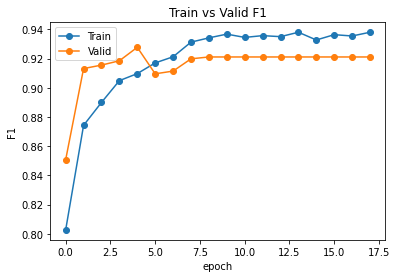

In [94]:
# freeze inception seed 7 bin 40%
show_graph(train_f1_list, val_f1_list, epoch_list)

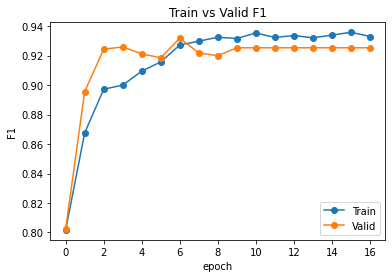

In [96]:
# freeze inception seed 0 bin 30%
show_graph(train_f1_list, val_f1_list, epoch_list)

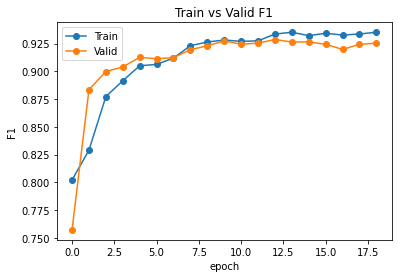

In [94]:
# freeze inception seed 25 bin 30%
show_graph(train_f1_list, val_f1_list, epoch_list)

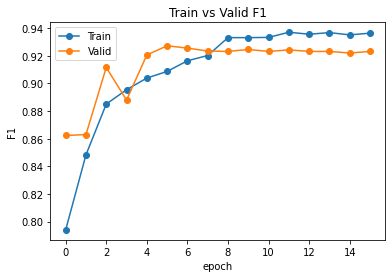

In [96]:
# freeze inception seed 25 bin 20%
show_graph(train_f1_list, val_f1_list, epoch_list)

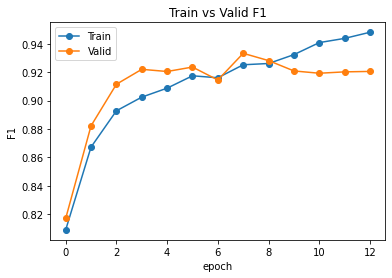

In [95]:
# freeze inception seed 7 bin 20%
show_graph(train_f1_list, val_f1_list, epoch_list)

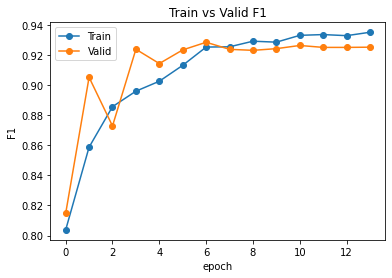

In [94]:
# freeze inception seed 66 bin 20%
show_graph(train_f1_list, val_f1_list, epoch_list)

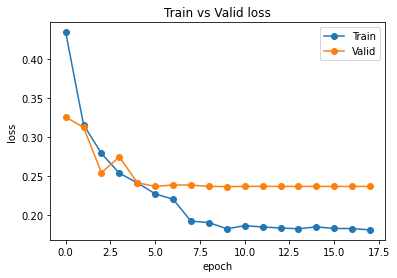

In [95]:
# freeze inception seed 7 bin 40%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

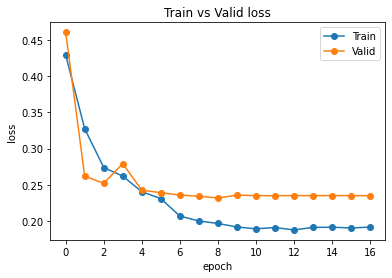

In [97]:
# freeze inception seed 0 bin 30%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

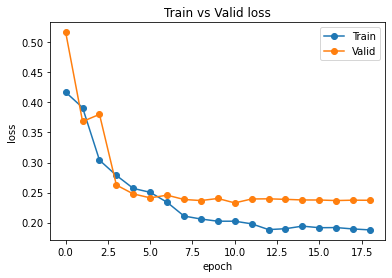

In [95]:
# freeze inception seed 25 bin 30%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

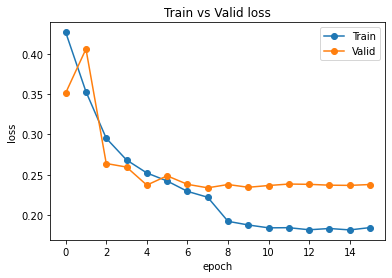

In [97]:
# freeze inception seed 25 bin 20%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

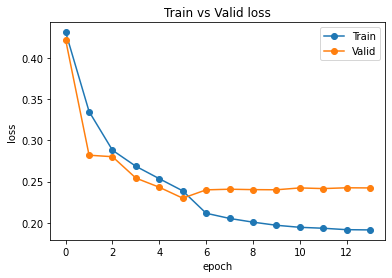

In [95]:
# freeze inception seed 66 bin 20%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

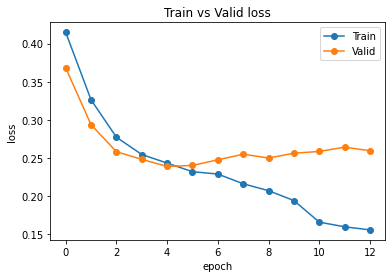

In [96]:
# freeze inception seed 7 bin 20%
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [78]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [76]:
epochs = 10
model = freeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
early_stopping(checkpoint['loss'])
criterion = nn.CrossEntropyLoss()
min_loss = checkpoint['loss']


for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  writer.flush()
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)

testing(model, dm)

159,621,451 total parameters.
788,611 training parameters.
Epoch 0 of 10
Epoch 0 Step 79 ave_loss 0.6103
Epoch 0 Step 159 ave_loss 0.6434
Epoch 0 Step 239 ave_loss 0.6054
Epoch 0 Step 319 ave_loss 0.5624
Epoch 0 Step 399 ave_loss 0.5728
Epoch 0 Step 479 ave_loss 0.6950
Epoch 0 Step 559 ave_loss 0.6405
Epoch 0 Step 639 ave_loss 0.6236
Epoch 0 Step 719 ave_loss 0.6085
Epoch 0 Step 799 ave_loss 0.5860
Epoch 0 Step 879 ave_loss 0.6133
Epoch 0 Step 959 ave_loss 0.6295
Epoch 0 Step 1039 ave_loss 0.5906
[[1527  209  199]
 [  83 3772  550]
 [ 208 1035 1217]]
Train acc 0.7404545454545455
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       242
         1.0       0.82      0.79      0.81       551
         2.0       0.59      0.65      0.62       308

    accuracy                           0.76      1101
   macro avg       0.76      0.75      0.75      1101
weighted avg       0.77      0.76      0.76      1101

[[195  16  31]
 [  4 438 109]
 [ 

Epoch 7 Step 159 ave_loss 0.5261
Epoch 7 Step 239 ave_loss 0.4442
Epoch 7 Step 319 ave_loss 0.4988
Epoch 7 Step 399 ave_loss 0.5274
Epoch 7 Step 479 ave_loss 0.4470
Epoch 7 Step 559 ave_loss 0.4833
Epoch 7 Step 639 ave_loss 0.4785
Epoch 7 Step 719 ave_loss 0.5302
Epoch 7 Step 799 ave_loss 0.5249
Epoch 7 Step 879 ave_loss 0.5057
Epoch 7 Step 959 ave_loss 0.4883
Epoch 7 Step 1039 ave_loss 0.5043
[[1595  166  174]
 [  38 3950  417]
 [ 133  816 1511]]
Train acc 0.8018181818181818
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85       242
         1.0       0.77      0.84      0.80       551
         2.0       0.61      0.51      0.56       308

    accuracy                           0.75      1101
   macro avg       0.74      0.73      0.74      1101
weighted avg       0.74      0.75      0.74      1101

[[204  19  19]
 [  7 464  80]
 [ 29 121 158]]
INFO: Early stopping counter 2 of 5
Train Loss: 0.4928
Val Loss: 0.5912
Val Acc: 0.7502
Epoc

In [96]:
import gc
del model 
gc.collect()

7417

In [97]:
torch.cuda.empty_cache()

In [98]:
PATH = "my_checkpoint_attention_seed_84_bin_img_20%.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


9


In [189]:
#f1
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       302
         1.0       0.96      0.96      0.96       695

    accuracy                           0.94       997
   macro avg       0.93      0.93      0.93       997
weighted avg       0.94      0.94      0.94       997

test_ac 0.9428284854563691
Confusion [[275  27]
 [ 30 665]]
Macro_f1 0.9324998307418023


In [99]:
#valloss
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       302
         1.0       0.96      0.97      0.96       695

    accuracy                           0.95       997
   macro avg       0.94      0.94      0.94       997
weighted avg       0.95      0.95      0.95       997

test_ac 0.9478435305917753
Confusion [[273  29]
 [ 23 672]]
Macro_f1 0.9378970972966238


In [75]:
optimizer = torch.optim.Adam([
        {'params': model.BERT.lstm.parameters()},  
        {'params': model.incept.flat.parameters()}, 
        {'params': model.incept.avgpool.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},       
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-5}
    ], lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [98]:
torch.cuda.empty_cache()

In [99]:
!nvidia-smi

Sun Mar 20 23:13:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   35C    P2    43W / 250W |  11004MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


